In [26]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt

In [27]:
def index_from_array(nparray):
  index = None
  for num in nparray[0]:
    index = num
    break
  return index

def show_images(src_img, des_img, res_img):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
    plt.title('Source Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(des_img, cv2.COLOR_BGR2RGB))
    plt.title('Destination Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
    plt.title('Output Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def save_image(img):
   cv2.imwrite('./media/output/result.png', img)

In [28]:
source_img = cv2.imread('./media/images/Bradley-cooper.webp')
source_img_grayscale = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)

destination_img = cv2.imread('./media/images/Jim_Carrey.jpg')
destination_img_grayscale = cv2.cvtColor(destination_img, cv2.COLOR_BGR2GRAY)

In [29]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./dataset/shape_predictor_68_face_landmarks.dat")

In [30]:
source_image_canvas = np.zeros_like(source_img_grayscale)
height, width, no_of_channels = destination_img.shape # Trả về cao, rộng và số kênh màu của ảnh
destination_image_canvas = np.zeros((height, width, no_of_channels), np.uint8)

In [31]:
source_faces = detector(source_img_grayscale)
# Obtaining source face landmark points, convex hull, creating mask and also getting delaunay triangle face landmark indices for every face
for face in source_faces:
  landmarks = predictor(source_img_grayscale, face)
  source_face_landmark_points = []

  # Lấy tọa độ khuôn mặt
  for landmark_no in range(0, 68):
    x_point = landmarks.part(landmark_no).x
    y_point = landmarks.part(landmark_no).y
    source_face_landmark_points.append((x_point, y_point))

    # cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
  source_face_landmark_points_array = np.array(source_face_landmark_points, np.int32)
  source_face_convexhull = cv2.convexHull(source_face_landmark_points_array)
  # cv2.polylines(img, [source_face_convexhull], True, (255, 0, 0), 3)
  cv2.fillConvexPoly(source_image_canvas, source_face_convexhull, 255)
  source_face_image = cv2.bitwise_and(source_img, source_img, mask=source_image_canvas)
  
  # Delaunav triangulation
  bounding_rectangle = cv2.boundingRect(source_face_convexhull)
  subdiv = cv2.Subdiv2D(bounding_rectangle)
  subdiv.insert(source_face_landmark_points)
  triangles_vector = subdiv.getTriangleList()
  triangles_array = np.array(triangles_vector, dtype=np.int32)

  triangle_landmark_points_list = []
  source_face_image_copy = source_face_image.copy()

  for t in triangles_array:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    index_1 = np.where((source_face_landmark_points_array == pt1).all(axis=1))
    index_1 = index_from_array(index_1)

    index_2 = np.where((source_face_landmark_points_array == pt2).all(axis=1))
    index_2 = index_from_array(index_2)

    index_3 = np.where((source_face_landmark_points_array == pt3).all(axis=1))
    index_3 = index_from_array(index_3)

    if index_1 is not None and index_2 is not None and index_3 is not None:
      triangle = [index_1, index_2, index_3]
      triangle_landmark_points_list.append(triangle)

    # cv2.line(img, pt1, pt2, (0, 0, 255), 2)
    # cv2.line(img, pt2, pt3, (0, 0, 255), 2)
    # cv2.line(img, pt1, pt3, (0, 0, 255), 2)

In [32]:
destination_faces = detector(destination_img_grayscale)
# Obtaining destination face landmark points and also convex hull for every face
for face in destination_faces:
  landmarks = predictor(destination_img_grayscale, face)
  destination_face_landmark_points = []

  for landmark_no in range(0, 68):
    x_point = landmarks.part(landmark_no).x
    y_point = landmarks.part(landmark_no).y
    destination_face_landmark_points.append((x_point, y_point))

    # cv2.circle(img2, (x, y), 3, (0, 255, 0), -1)
    destination_face_landmark_points_array = np.array(destination_face_landmark_points, np.int32)
    destination_face_convexhull = cv2.convexHull(destination_face_landmark_points_array)

In [33]:
# Iterating through all source delaunay triangle and superimposing source triangles in empty destination canvas after warping to same size as destination triangles' shape
for i, triangle_index_points in enumerate(triangle_landmark_points_list):
  # Cropping source triangle's bounding rectangle
  source_triangle_point_1 = source_face_landmark_points[triangle_index_points[0]]
  source_triangle_point_2 = source_face_landmark_points[triangle_index_points[1]]
  source_triangle_point_3 = source_face_landmark_points[triangle_index_points[2]]
  source_triangle = np.array([source_triangle_point_1, source_triangle_point_2, source_triangle_point_3], np.int32)

  source_rectangle = cv2.boundingRect(source_triangle)
  (x, y, w, h) = source_rectangle
  cropped_source_rectangle = source_img[y: y + h, x: x + w]
  source_triangle_points = np.array([[source_triangle_point_1[0] - x, source_triangle_point_1[1] - y],
                    [source_triangle_point_2[0] - x, source_triangle_point_2[1] - y],
                    [source_triangle_point_3[0] - x, source_triangle_point_3[1] - y]], np.int32)

  # cv2.line(img, tr1_pt1, tr1_pt2, (0, 0, 255), 2)
  # cv2.line(img, tr1_pt3, tr1_pt2, (0, 0, 255), 2)
  # cv2.line(img, tr1_pt1, tr1_pt3, (0, 0, 255), 2)

  # Create a mask using cropped destination triangle's bounding rectangle(for same landmark points as used for source triangle)
  destination_triangle_point_1 = destination_face_landmark_points[triangle_index_points[0]]
  destination_triangle_point_2 = destination_face_landmark_points[triangle_index_points[1]]
  destination_triangle_point_3 = destination_face_landmark_points[triangle_index_points[2]]
  destination_triangle = np.array([destination_triangle_point_1, destination_triangle_point_2, destination_triangle_point_3], np.int32)

  destination_rectangle = cv2.boundingRect(destination_triangle)
  (x, y, w, h) = destination_rectangle
  cropped_destination_rectangle_mask = np.zeros((h, w), np.uint8)

  destination_triangle_points = np.array([[destination_triangle_point_1[0]-x, destination_triangle_point_1[1]-y], 
                                    [destination_triangle_point_2[0]-x, destination_triangle_point_2[1]-y], 
                                    [destination_triangle_point_3[0]-x, destination_triangle_point_3[1]-y]], np.int32)

  cv2.fillConvexPoly(cropped_destination_rectangle_mask, destination_triangle_points, 255)
  # Warp source triangle to match shape of destination triangle and put it over destination triangle mask

  # cv2.line(img2, tr2_pt1, tr2_pt2, (0, 0, 255), 2)
  # cv2.line(img2, tr2_pt3, tr2_pt2, (0, 0, 255), 2)
  # cv2.line(img2, tr2_pt1, tr2_pt3, (0, 0, 255), 2)

  # Wrap triangles
  source_triangle_points = np.float32(source_triangle_points)
  destination_triangle_points = np.float32(destination_triangle_points)

  M = cv2.getAffineTransform(source_triangle_points, destination_triangle_points)
  warped_triangle = cv2.warpAffine(cropped_source_rectangle, M, (w, h))

  warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_destination_rectangle_mask)

  # Reconstructing destination face in empty canvas of destination image

  # removing white lines in triangle using masking
  new_dest_face_canvas_area = destination_image_canvas[y: y + h, x: x + w]
  new_dest_face_canvas_area_gray =  cv2.cvtColor(new_dest_face_canvas_area, cv2.COLOR_BGR2GRAY)
  _, mask_created_triangle = cv2.threshold(new_dest_face_canvas_area_gray, 1, 255, cv2.THRESH_BINARY_INV)

  warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_created_triangle)
  new_dest_face_canvas_area = cv2.add(new_dest_face_canvas_area, warped_triangle)
  destination_image_canvas[y:y+h, x:x+w] = new_dest_face_canvas_area

In [34]:
# Put reconstructed face on the destination image
final_destination_canvas = np.zeros_like(destination_img_grayscale)
final_destination_face_mask = cv2.fillConvexPoly(final_destination_canvas, destination_face_convexhull, 255)
final_destination_canvas = cv2.bitwise_not(final_destination_face_mask)
destination_face_masked = cv2.bitwise_and(destination_img, destination_img, mask=final_destination_canvas)
destination_with_face = cv2.add(destination_face_masked, destination_image_canvas)

In [35]:
# Make the face look more naturally
(x, y, w, h) = cv2.boundingRect(destination_face_convexhull)
destination_face_center_point = (int((x+x+w)/2), int((y+y+h)/2))
seamless_cloned_face = cv2.seamlessClone(destination_with_face, destination_img, final_destination_face_mask, destination_face_center_point, cv2.NORMAL_CLONE)

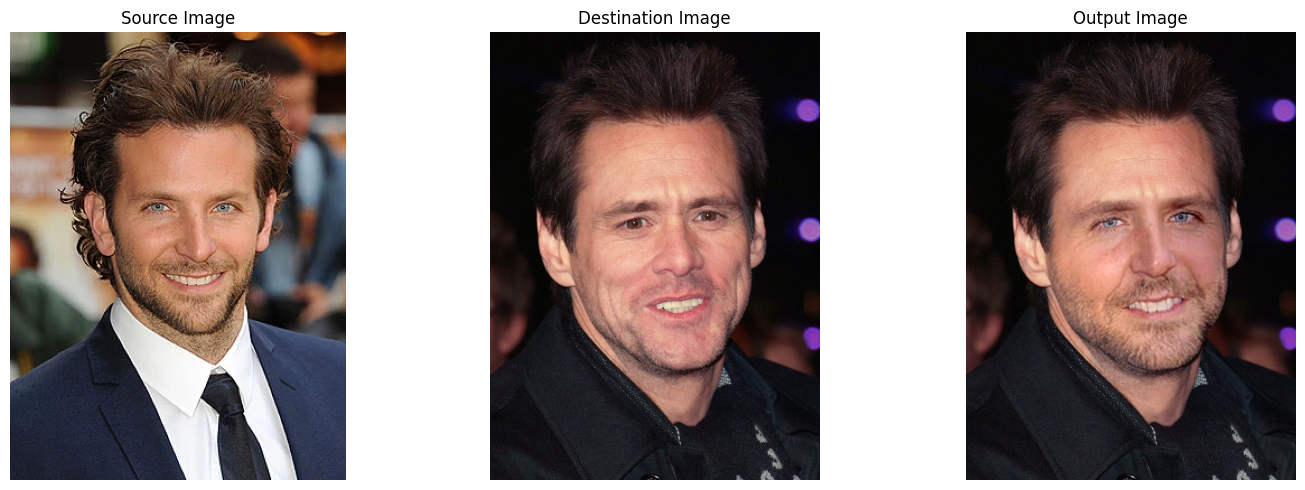

In [36]:
show_images(source_img, destination_img, seamless_cloned_face)
save_image(seamless_cloned_face)